<a href="https://colab.research.google.com/github/fpesceKU/EnsembleLab/blob/main/EnsembleLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preliminary information:**




*   This Colab notebook enables running simulations of intrinsically disordered proteins (IDPs) and to study their conformational ensembles in combination with experimental data.
*   Molecular dynamics (MD) simulations employ the coarse-grained force fields CALVADOS2, where each residue is mapped onto a single bead and parametrized with a "stickiness" parameter.
*   Simulations only require that the user provides the sequence of an IDP and set environmental conditions (temperature, salt concentration, pH).
*   If experimental data are available for the IDP, the Bayesian/Maximum-entropy reweighting can be used to refine ensembles to better match the experimental data.
*   Multiple structural observables can be calculated from simulations.
*   MD simulations run on GPU. To enable GPU select `Runtime` from the menu, then `Change runtime type` and select `GPU`.


---



In [1]:
#@title <b>Preliminary operations</b>: acquiring softwares
%%bash
rm -r *

wget https://cssb.biology.gatech.edu/skolnick/files/PULCHRA/pulchra304.tgz &> /dev/null
tar -zxf pulchra304.tgz &> /dev/null
rm pulchra304.tgz
mv ./pulchra304/bin/linux/pulchra .
chmod +x pulchra
rm -r pulchra304/

wget https://files.inria.fr/NanoDFiles/Website/Software/Pepsi-SAXS/Linux/3.0/Pepsi-SAXS-Linux.zip &> /dev/null
unzip Pepsi-SAXS-Linux.zip &> /dev/null
rm Pepsi-SAXS-Linux.zip

wget https://raw.githubusercontent.com/fpesceKU/BLOCKING/main/block_tools.py &> /dev/null
wget https://raw.githubusercontent.com/fpesceKU/BLOCKING/main/main.py &> /dev/null

wget https://raw.githubusercontent.com/KULL-Centre/BME/main/BME_tools.py &> /dev/null
wget https://raw.githubusercontent.com/KULL-Centre/BME/main/BME.py &> /dev/null

wget https://raw.githubusercontent.com/ehb54/GenApp-BayesApp/main/bin/source/bift.f &> /dev/null
gfortran bift.f -march=native -O2 -o bift

In [ ]:
#@title <b>Preliminary operations</b>: setting the environment (i)
import google.colab
! pip install condacolab &> /dev/null
! pip install wget &> /dev/null
! pip install -q nglview &> /dev/null
import condacolab
condacolab.install()

print('Installing libraries...')
! conda install matplotlib mdtraj openmm=7.5 -c conda-forge --yes &> /dev/null

In [ ]:
#@title <b>Preliminary operations</b>: setting the environment (ii)
import os
import shutil
import subprocess
import wget
import numpy as np
import scipy.stats as scs
from scipy.optimize import curve_fit
import pandas as pd
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
from simtk import openmm, unit
from simtk.openmm import app
import BME as BME
from google.colab import output
output.enable_custom_widget_manager()
import nglview as nv

In [2]:
#@title <b><font color='#b22222'>1.1 MD Toolbox</font></b>
wget.download('https://raw.githubusercontent.com/KULL-Centre/CALVADOS/main/residues.csv')

residues = pd.read_csv('residues.csv')
residues = residues.set_index('one')

def genParamsLJ(df,seq):
    fasta = seq.copy()
    r = df.copy()
    r.loc['X'] = r.loc[fasta[0]]
    r.loc['Z'] = r.loc[fasta[-1]]
    r.loc['X','MW'] += 2
    r.loc['Z','MW'] += 16
    fasta[0] = 'X'
    fasta[-1] = 'Z'
    types = list(np.unique(fasta))
    lj_eps = 0.2*4.184
    lj_sigma = pd.DataFrame((r.sigmas.values+r.sigmas.values.reshape(-1,1))/2,
                            index=r.sigmas.index,columns=r.sigmas.index)
    lj_lambda = pd.DataFrame((r.lambdas.values+r.lambdas.values.reshape(-1,1))/2,
                             index=r.lambdas.index,columns=r.lambdas.index)
    return lj_eps, lj_sigma, lj_lambda, fasta, types

def genParamsDH(df,seq,temp,pH,ionic):
    kT = 8.3145*temp*1e-3
    fasta = seq.copy()
    r = df.copy()
    # Set the charge on HIS based on the pH of the protein solution
    r.loc['H','q'] = 1. / ( 1 + 10**(pH-6) )
    r.loc['X'] = r.loc[fasta[0]]
    r.loc['Z'] = r.loc[fasta[-1]]
    fasta[0] = 'X'
    fasta[-1] = 'Z'
    r.loc['X','q'] = r.loc[seq[0],'q'] + 1.
    r.loc['Z','q'] = r.loc[seq[-1],'q'] - 1.
    # Calculate the prefactor for the Yukawa potential
    fepsw = lambda T : 5321/T+233.76-0.9297*T+0.1417*1e-2*T*T-0.8292*1e-6*T**3
    epsw = fepsw(temp)
    lB = 1.6021766**2/(4*np.pi*8.854188*epsw)*6.022*1000/kT
    yukawa_eps = [r.loc[a].q*np.sqrt(lB*kT) for a in fasta]
    # Calculate the inverse of the Debye length
    yukawa_kappa = np.sqrt(8*np.pi*lB*ionic*6.022/10)
    return yukawa_eps, yukawa_kappa

def genDCD(name, eqsteps=1000):
    """ 
    Generates coordinate and trajectory
    in convenient formats
    """
    traj = md.load("{:s}/pretraj.dcd".format(name), top="{:s}/top.pdb".format(name))
    traj = traj.image_molecules(inplace=False, anchor_molecules=[set(traj.top.chain(0).atoms)], make_whole=True)
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2
    tocut = eqsteps #10 ns (eq)
    traj[int(tocut):].save_dcd("{:s}/traj.dcd".format(name))

def simulate(residues,name,seq,temp,pH,ionic,nsteps,stride=1e3,eqsteps=1000):
    os.mkdir(name)

    lj_eps, _, _, fasta, types= genParamsLJ(residues,seq)
    yukawa_eps, yukawa_kappa = genParamsDH(residues,seq,temp,pH,ionic)

    N = len(fasta)

    L = 200

    system = openmm.System()

    # set box vectors
    a = unit.Quantity(np.zeros([3]), unit.nanometers)
    a[0] = L * unit.nanometers
    b = unit.Quantity(np.zeros([3]), unit.nanometers)
    b[1] = L * unit.nanometers
    c = unit.Quantity(np.zeros([3]), unit.nanometers)
    c[2] = L * unit.nanometers
    system.setDefaultPeriodicBoxVectors(a, b, c)
    
    top = md.Topology()
    pos = []
    chain = top.add_chain()
    pos.append([[0,0,L/2+(i-N/2.)*.38] for i in range(N)])
    for resname in fasta:
        residue = top.add_residue(resname, chain)
        top.add_atom(resname, element=md.element.carbon, residue=residue)
    for i in range(chain.n_atoms-1):
        top.add_bond(chain.atom(i),chain.atom(i+1))
    md.Trajectory(np.array(pos).reshape(N,3), top, 0, [L,L,L], [90,90,90]).save_pdb('{:s}/top.pdb'.format(name))

    pdb = app.pdbfile.PDBFile('{:s}/top.pdb'.format(name))

    system.addParticle((residues.loc[seq[0]].MW+2)*unit.amu)
    for a in seq[1:-1]:
        system.addParticle(residues.loc[a].MW*unit.amu) 
    system.addParticle((residues.loc[seq[-1]].MW+16)*unit.amu)

    hb = openmm.openmm.HarmonicBondForce()
    energy_expression = 'select(step(r-2^(1/6)*s),4*eps*l*((s/r)^12-(s/r)^6),4*eps*((s/r)^12-(s/r)^6)+eps*(1-l))'
    ah = openmm.openmm.CustomNonbondedForce(energy_expression+'; s=0.5*(s1+s2); l=0.5*(l1+l2)')
    yu = openmm.openmm.CustomNonbondedForce('q*(exp(-kappa*r)/r - exp(-kappa*4)/4); q=q1*q2')
    yu.addGlobalParameter('kappa',yukawa_kappa/unit.nanometer)
    yu.addPerParticleParameter('q')

    ah.addGlobalParameter('eps',lj_eps*unit.kilojoules_per_mole)
    ah.addPerParticleParameter('s')
    ah.addPerParticleParameter('l')
 
    for a,e in zip(seq,yukawa_eps):
        yu.addParticle([e*unit.nanometer*unit.kilojoules_per_mole])
        ah.addParticle([residues.loc[a].sigmas*unit.nanometer, residues.loc[a].lambdas*unit.dimensionless])

    for i in range(N-1):
        hb.addBond(i, i+1, 0.38*unit.nanometer, 8033*unit.kilojoules_per_mole/(unit.nanometer**2))
        yu.addExclusion(i, i+1)
        ah.addExclusion(i, i+1)

    yu.setForceGroup(0)
    ah.setForceGroup(1)
    yu.setNonbondedMethod(openmm.openmm.CustomNonbondedForce.CutoffPeriodic)
    ah.setNonbondedMethod(openmm.openmm.CustomNonbondedForce.CutoffPeriodic)
    hb.setUsesPeriodicBoundaryConditions(True)
    yu.setCutoffDistance(4*unit.nanometer)
    ah.setCutoffDistance(2*unit.nanometer)
 
    system.addForce(hb)
    system.addForce(yu)
    system.addForce(ah)

    #serialized_system = XmlSerializer.serialize(system)
    #outfile = open('system.xml','w')
    #outfile.write(serialized_system)
    #outfile.close()

    integrator = openmm.openmm.LangevinIntegrator(temp*unit.kelvin,0.01/unit.picosecond,0.010*unit.picosecond) #10 fs timestep

    platform = openmm.Platform.getPlatformByName('CUDA')

    simulation = app.simulation.Simulation(pdb.topology, system, integrator, platform, dict(CudaPrecision='mixed')) 

    check_point = '{:s}/restart.chk'.format(name)

    if os.path.isfile(check_point):
        print('Reading check point file')
        simulation.loadCheckpoint(check_point)
        simulation.reporters.append(app.dcdreporter.DCDReporter('{:s}/pretraj.dcd'.format(name),int(stride),append=True))
    else:
        simulation.context.setPositions(pdb.positions)
        simulation.minimizeEnergy()
        simulation.reporters.append(app.dcdreporter.DCDReporter('{:s}/pretraj.dcd'.format(name),int(stride)))

    simulation.reporters.append(app.statedatareporter.StateDataReporter('{:s}/traj.log'.format(name),int(stride),
             potentialEnergy=True,temperature=True,step=True,speed=True,elapsedTime=True,separator='\t'))

    simulation.step(nsteps)

    simulation.saveCheckpoint(check_point)

    genDCD(name,eqsteps)

In [126]:
#@title <b><font color='#b22222'>1.2 Analysis Toolbox</font></b>
from main import BlockAnalysis

def autoblock(cv, multi=1, plot=False):
    block = BlockAnalysis(cv, multi=multi)
    block.SEM()

    if plot == True:
        plt.errorbar(block.stat[...,0], block.stat[...,1], block.stat[...,2], fmt='', color='k', ecolor='0.5')
        plt.scatter(block.bs, block.sem,zorder=10,c='tab:red')
        plt.xlabel('Block size')
        plt.ylabel('SEM')
        plt.show()

    return block.av, block.sem, block.bs

def Rg(name, seq):
    t = md.load_dcd('{:s}/traj.dcd'.format(name), top='{:s}/top.pdb'.format(name))
    masses = residues.loc[list(seq),'MW'].values
    rgarray = md.compute_rg(t,masses=masses)
    return rgarray

def invRh(name):
    t = md.load_dcd('{:s}/traj.dcd'.format(name), top='{:s}/top.pdb'.format(name))
    n = len(list(t.topology.residues))
    return (1-1/n)*(1/md.compute_distances(t,t.top.select_pairs('all','all'))).mean(axis=1)

def Dmax(name):
    t = md.load_dcd('{:s}/traj.dcd'.format(name), top='{:s}/top.pdb'.format(name))
    pairs = t.top.select_pairs('all','all')
    d = md.compute_distances(t,pairs)
    return np.max(d)

def fix_topology(t,seq):
    cgtop = md.Topology()
    cgchain = cgtop.add_chain()
    for res in seq:
        cgres = cgtop.add_residue(res, cgchain)
        cgtop.add_atom('CA', element=md.element.carbon, residue=cgres)
    traj = md.Trajectory(t.xyz, cgtop, t.time, t.unitcell_lengths, t.unitcell_angles)
    traj = traj.superpose(traj, frame=0)
    return traj

def Dee(name):
    t = md.load_dcd('{:s}/traj.dcd'.format(name), top='{:s}/top.pdb'.format(name))
    return md.compute_distances( t, atom_pairs=np.array([[ 0,  len(list(t.top.atoms))-1]]) )[...,0]

def Rij(name, r0_fix=0.68):
    traj = md.load_dcd('{:s}/traj.dcd'.format(name), top='{:s}/top.pdb'.format(name))
    pairs = traj.top.select_pairs('all','all')
    d = md.compute_distances(traj,pairs)
    dmean = d.mean(axis=0)
    ij = np.array(range(1,traj.n_atoms))
    diff = [x[1]-x[0] for x in pairs]
    dij = np.empty(0)
    for i in ij:
        dij = np.append(dij,dmean[diff==i].mean())
    
    f = lambda x,v : r0_fix*np.power(x,v)
    popt, pcov = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.5])
    nu = popt[0]
    return ij, dij, nu

def kde(a, w=None):
    if type(w) == 'NoneType':
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = np.average(a, weights = w)
    return x,d/np.sum(d),u

def plot_dist(ax,x,p,av,err):
    ax.plot(x,p,c='k')
    ax.vlines(av,0,np.max(p)+0.1*np.max(p), color='k')
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(0,np.max(p)+0.1*np.max(p))

In [4]:
#@title <b><font color='#b22222'>1.3 BME Toolbox</font></b>
def iBME(calc_file,exp_file,THETAS=[1,10,20,50,75,100,200,400,750,1000,5000,10000]):
    W = []
    STATS = []

    for t in THETAS:
        print('Reweighting with theta={}'.format(t))
        rew = BME.Reweight('ibme_t{}'.format(t))
        rew.load(exp_file,calc_file)
        rew.ibme(theta=t, iterations=25, ftol=0.001)
        
        W.append(rew.get_ibme_weights())
        STATS.append(rew.get_ibme_stats()[-1])
        print(STATS[-1])

    return STATS, W

In [ ]:
#@title <b><font color='#ffc413'>2. IDP sequence and data</font></b>

#@markdown Name the IDP that you want to simulate:
NAME = "Hst5" #@param {type:"string"}

#@markdown Insert here the sequence of the IDP that you want to simulate:
SEQUENCE = "DSHAKRHHGYKRKFHEKHHSHRGY" #@param {type:"string"}

#@markdown Are experimental data available for this IDP? If so, a prompt will appear where you can provide the location of the data.
EXPERIMENT = "SAXS" #@param ["None", "SAXS", "Rh"]

if EXPERIMENT == "SAXS":
    print('SAXS data must be in a file containing 3 columns, which are q, I and sigma. Commented lines (#) are allowed.')
    link_to_data = input('Link to your experimental data: ')
    saxs_file = wget.download(link_to_data)

    #check data
    try:
        np.loadtxt(saxs_file)
    except:
        print("Unable to read file. Make sure the file only contains 3 columns (q,I,sigma) and #commented lines")
    assert np.shape(np.loadtxt(saxs_file))[1] == 3, "Expected file with 3 columns (q,I,sigma)"

SAXS data must be in a file containing 3 columns, which are q, I and sigma. Commented lines (#) are allowed.


In [6]:
#@title <b><font color='#ffc413'>3.1 Launch MD simulation</font></b>
#@markdown Settings:
Temperature = 298 #@param {type:"number"}
Ionic_strenght = 0.150 #@param {type:"number"}
pH = 7.0 #@param {type:"number"}
Length = "AUTO" #@param {type:"raw"}

#@markdown <i>*Units: Temperature [K], Ionic_strength [M], Length [ns]<i>
if Length == "AUTO":
    N_res = len(SEQUENCE)
    L = (N_res-1)*0.38+4
    N_save = 7000 if N_res < 150 else int(np.ceil(3e-4*N_res**2)*1000)
    nsteps = 1010*N_save
    print('AUTO simulation length selected. Running for {} ns'.format(nsteps*0.01/1000))
else:
    nsteps = Length*1000/0.01
simulate(residues,NAME,list(SEQUENCE),temp=Temperature,pH=pH,ionic=Ionic_strenght,nsteps=nsteps,stride=1e3,eqsteps=1000)

In [26]:
#@title <b><font color='#ffc413'>3.2 Visualize MD simulation</font></b>
t = md.load_dcd('{:s}/traj.dcd'.format(NAME), top='{:s}/top.pdb'.format(NAME))
p_view = nv.show_mdtraj(t)
p_view.clear_representations()
p_view.add_ball_and_stick()
p_view

NGLWidget(max_frame=4899)

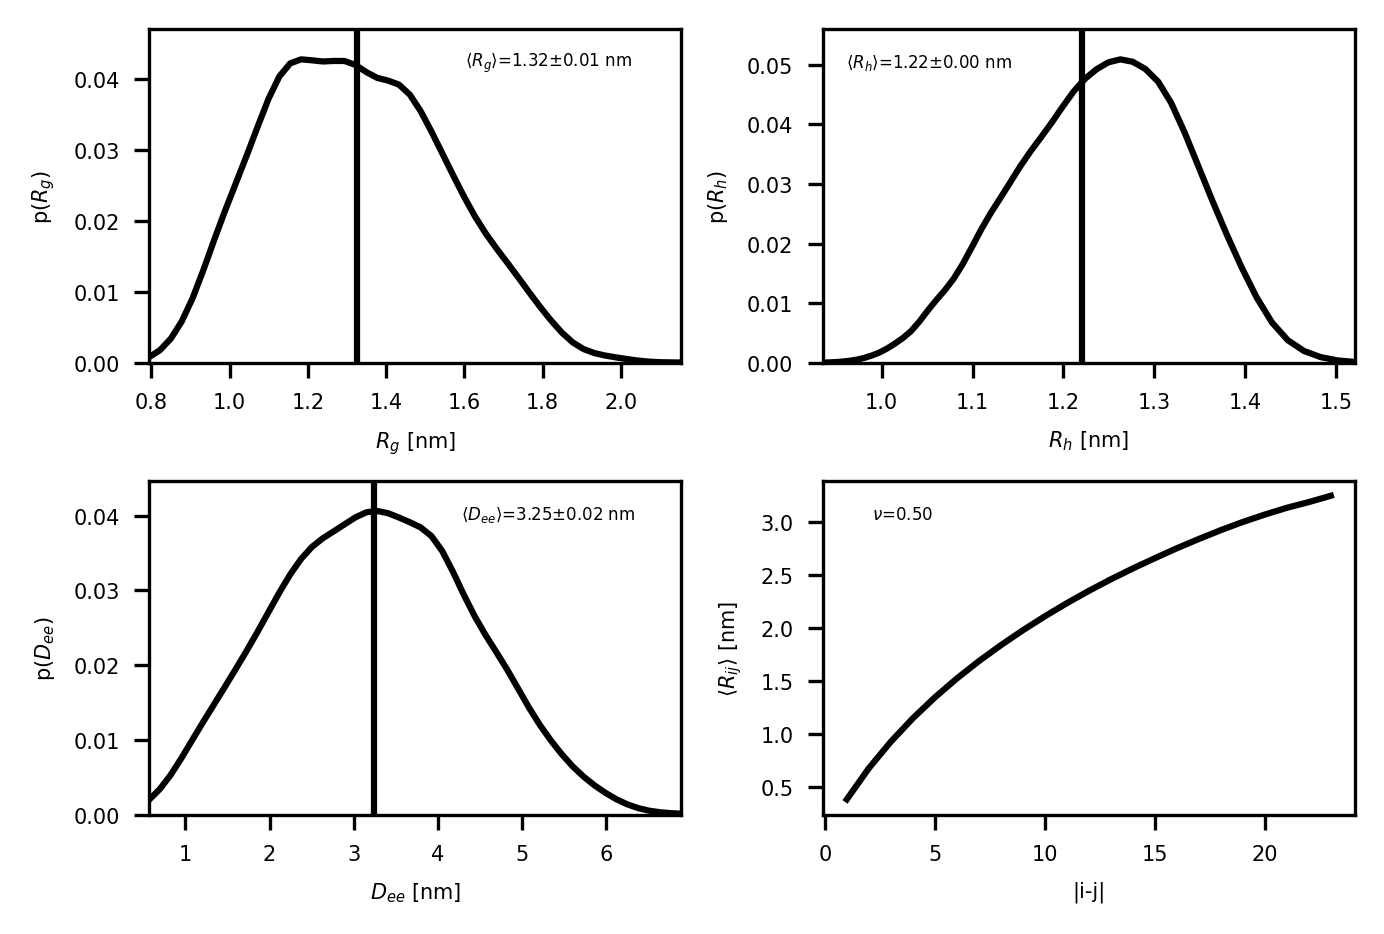

In [147]:
#@title <b><font color='#ffc413'>3.3 Calculate structural observables from simulation</font></b>
rg_array = Rg(NAME, SEQUENCE)
rg_av, rg_err, rg_bs = autoblock(rg_array, plot=False)
x_rg, p_rg, _ = kde(rg_array)

invrh = invRh(NAME)
tmp = autoblock(invrh, plot=False)
rh_av = 1/tmp[0]
rh_err = rh_av*tmp[1]/tmp[0]
rh_bs = tmp[2]
tmp, p_rh, _ = kde(invrh)
x_rh = 1/tmp

dee_array = Dee(NAME)
dee_av, dee_err, dee_bs = autoblock(dee_array, plot=False)
x_dee, p_dee, _ = kde(dee_array)

ij, dij, nu = Rij(NAME)

mpl.rcParams.update({'font.size': 5})
fig, axs = plt.subplots(2, 2, figsize=(4.5,3), facecolor='w', dpi=300, layout='constrained')
axs = axs.flatten()

plot_dist(axs[0], x_rg, p_rg, rg_av, rg_err)
axs[0].set_xlabel(r'$R_g$ [nm]')
axs[0].set_ylabel(r'p($R_g$)')
axs[0].text(0.75, 0.9, r'$\langle R_g \rangle$={:.2f}$\pm{:.2f}$ nm'.format(rg_av,rg_err), horizontalalignment='center',verticalalignment='center', transform=axs[0].transAxes, fontsize=4)

plot_dist(axs[1], x_rh, p_rh, rh_av, rh_err)
axs[1].set_xlabel(r'$R_h$ [nm]')
axs[1].set_ylabel(r'p($R_h$)')
axs[1].text(0.2, 0.9, r'$\langle R_h \rangle$={:.2f}$\pm{:.2f}$ nm'.format(rh_av,rh_err), horizontalalignment='center',verticalalignment='center', transform=axs[1].transAxes, fontsize=4)

plot_dist(axs[2], x_dee, p_dee, dee_av, dee_err)
axs[2].set_xlabel(r'$D_{ee}$ [nm]')
axs[2].set_ylabel(r'p($D_{ee}$)')
axs[2].text(0.75, 0.9, r'$\langle D_{ee} \rangle$'+'={:.2f}$\pm{:.2f}$ nm'.format(dee_av,dee_err), horizontalalignment='center',verticalalignment='center', transform=axs[2].transAxes, fontsize=4)

axs[3].plot(ij,dij,c='k')
axs[3].set_xlabel('|i-j|')
axs[3].set_ylabel(r'$\langle R_{ij} \rangle$ [nm]')
axs[3].text(0.15, 0.9, r'$\nu$={:.2f}'.format(nu).format(dee_av,dee_err), horizontalalignment='center',verticalalignment='center', transform=axs[3].transAxes, fontsize=4)

plt.show()

In [148]:
#@title <b><font color='#ffc413'>4.1 Ensemble reweighting with experimental data</b>: getting data ready</font>
if EXPERIMENT == 'SAXS':

    #correct experimental errors with BIFT
    dmax = Dmax(NAME)
    f = open('inputfile.dat','w')
    f.write("{:s}\n\n\n\n{}\n\n\n\n\n\n\n\n\n\n\n\n".format(saxs_file,dmax))
    f.close()
    subprocess.run('./bift < inputfile.dat'.split())
    np.savetxt('{:s}_bift.dat'.format(NAME), np.loadtxt('rescale.dat'), header=' DATA=SAXS')
    print('Experimental errors on SAXS intensities have been corrected with BIFT')
    print('Factor used for rescaling errors is: {}'.format(np.loadtxt('scale_factor.dat')[0,1]))
    print('SAXS data with corrected errors is in {:s}_bift.dat'.format(NAME))

    #subsampling, backmapping, SAXS
    SEQ3 = [residues.three[x] for x in SEQUENCE]
    t_cg = fix_topology(md.load_dcd('{:s}/traj.dcd'.format(NAME), top='{:s}/top.pdb'.format(NAME)), SEQ3)
    for i in np.arange(0,len(t_cg),bs):
        t_cg[int(i)].save_pdb('frame.pdb')
        subprocess.run(['./pulchra', 'frame.pdb'])
        pepsi_comm = './Pepsi-SAXS frame.rebuilt.pdb {:s}_bift.dat -o saxs.dat -cst --cstFactor 0 --I0 1.0 --dro 1.0 --r0_min_factor 1.025 --r0_max_factor 1.025 --r0_N 1'.format(NAME)
        subprocess.run(pepsi_comm.split())
        if i == 0:
            calc_saxs = np.loadtxt('saxs.dat')[...,3]
        else:
            calc_saxs = np.vstack((calc_saxs,np.loadtxt('saxs.dat')[...,3]))
    col0 = np.arange(0,len(calc_saxs)).reshape(len(calc_saxs),1)
    calc_saxs = np.hstack((col0,calc_saxs))
    np.savetxt('calc_saxs.dat', calc_saxs)

elif EXPERIMENT == 'None':
    print('No experiment specified. Select type of experiment in cell 2.')
else:
  print('An unknown option is specified.')

Experimental errors on SAXS intensities have been corrected with BIFT
Factor used for rescaling errors is: 1.12356031
SAXS data with corrected errors is in Hst5_bift.dat


In [ ]:
#@title <b><font color='#ffc413'>4.2 Execute reweighting</b></font>
iBME('calc_saxs.dat', '{:s}_bift.dat'.format(NAME))

In [ ]:
#@title <b><font color='#ffc413'>4.3 Analyze reweighting</b></font>


In [ ]:
%%bash
ls

TODO list:
- CG SAXS
- students can write their own function to calculate rg?
- how does one input exp data?
- dmax to bift has to check for consistent units between dmax and q
- progress bar for simulation and reweighting
- implement rh, ree, nu
- keep trajectory in memory instead of opening it in every function
- dmax from Rij and not a dedicated function